In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss
from mpl_toolkits.axes_grid1 import ImageGrid

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

(30456,)
(30456,)


In [5]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [7]:
def make_circle_aperture(num_bins,radius):

    xs = np.arange(0,num_bins)
    ys = np.arange(0,num_bins)

    aperture = []
    for x in xs:
        for y in ys:
            if (x-num_bins/2)**2+(y-num_bins/2)**2<radius**2:
                aperture.append(1.)
            else:
                aperture.append(0.)
    aperture = np.asarray(aperture)
    aperture = np.reshape(aperture,(num_bins,num_bins))
    return aperture

Text(0.5, 0.72, 'Clusters 21, 271')

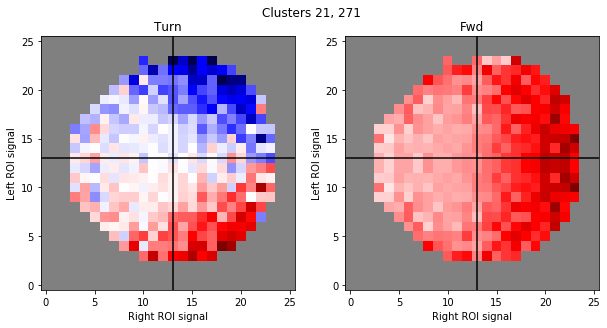

In [8]:
plt.figure(figsize=(10,10))

cluster_ = 21#185#77#147#47#21

x_data = supercluster_signals[cluster_,:]
y_data = supercluster_signals[cluster_+250,:]

r = np.deg2rad(45)
rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
m = np.vstack((x_data,y_data)).T
out = np.matmul(m,rot)
x_data = out[:,1]; y_data = out[:,0]

# model = PCA()
# pca = model.fit_transform(np.vstack((x_data,y_data)).T)
# x_data = pca[:, 1]
# y_data = pca[:, 0]

# x_data = x_data*np.std(y_data)/np.std(x_data) #make spherical

x_data /= np.std(x_data)/0.15
y_data /= np.std(y_data)/0.15 # normalize

behavior = beh_turn

for k,(behavior,title) in enumerate(zip([beh_turn, beh_fwd],['Turn','Fwd'])):
    plt.subplot(1,2,k+1)
    start=-.6
    stop=.6
    num_bins=40
    min_num_samples=10

    # Define bins
    bins = np.linspace(start,stop,num_bins)

    # Assign neural values to bin numbers
    idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

    binned_signal = []
    sample_count = []
    for i in range(num_bins):
        mask_x = (idx_x == i)
        for j in range(num_bins):
            mask_y = (idx_y == j)
            mask = mask_x & mask_y

            binned_signal.append(np.mean(behavior[mask]))
            sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

    binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
    sample_count = np.reshape(sample_count,(num_bins, num_bins))

    #smooth
    #binned_signal = scipy.ndimage.gaussian_filter(binned_signal,sigma=1,truncate=1)
    #binned_signal = scipy.ndimage.uniform_filter(binned_signal, size=2, mode='constant')

    # Symeterize
    if title == 'Turn':
        binned_signal = (binned_signal+binned_signal[::-1]*-1)/2
    elif title == 'Fwd':
        binned_signal = (binned_signal+binned_signal[::-1])/2
    
    # Hide bins containing too few data points
    sample_count = (sample_count+sample_count[::-1])/2
    binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

    #mask a circle
    radius = 11
    #binned_signal *= make_circle_aperture(num_bins,radius)
    aperture = make_circle_aperture(num_bins,radius)
    aperture[aperture==0]=np.nan
    binned_signal*=aperture
    
    #normalize
    binned_signal /= np.max(np.nan_to_num(binned_signal))
    
    #crop
    binned_signal = binned_signal[7:-7,7:-7]
    
    cmap = plt.cm.get_cmap("seismic")
    cmap.set_bad(color='grey')
    plt.imshow(binned_signal,vmin=-1,vmax=1,cmap=cmap,origin='lower')
    plt.ylabel('Left ROI signal')
    plt.xlabel('Right ROI signal')
    #plt.plot([0,num_bins],[0,num_bins],color='k')
    #plt.colorbar()
    #plt.ylim(7,num_bins-8)
    #plt.xlim(7,num_bins-8)
    plt.title(title)
    plt.axhline(13,color='k')
    plt.axvline(13,color='k')
plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

In [83]:
all_turn_hists = []
all_fwd_hists = []
all_turn_max = []
all_fwd_max = []

for cluster_ in tqdm.tqdm(range(251)):

    x_data = supercluster_signals[cluster_,:]
    y_data = supercluster_signals[cluster_+250,:]

    r = np.deg2rad(45)
    rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
    m = np.vstack((x_data,y_data)).T
    out = np.matmul(m,rot)
    x_data = out[:,1]; y_data = out[:,0]

    # model = PCA()
    # pca = model.fit_transform(np.vstack((x_data,y_data)).T)
    # x_data = pca[:, 1]
    # y_data = pca[:, 0]

    # x_data = x_data*np.std(y_data)/np.std(x_data) #make spherical

    x_data /= np.std(x_data)/0.15
    y_data /= np.std(y_data)/0.15 # normalize

    for k,(behavior,title) in enumerate(zip([beh_turn, beh_fwd],['Turn','Fwd'])):
        start=-.6
        stop=.6
        num_bins=40
        min_num_samples=10

        # Define bins
        bins = np.linspace(start,stop,num_bins)

        # Assign neural values to bin numbers
        idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

        binned_signal = []
        sample_count = []
        for i in range(num_bins):
            mask_x = (idx_x == i)
            for j in range(num_bins):
                mask_y = (idx_y == j)
                mask = mask_x & mask_y

                binned_signal.append(np.mean(behavior[mask]))
                sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

        binned_signal = np.reshape(binned_signal,(num_bins, num_bins))
        sample_count = np.reshape(sample_count,(num_bins, num_bins))

        #smooth
        #binned_signal = scipy.ndimage.gaussian_filter(binned_signal,sigma=1,truncate=1)
        #binned_signal = scipy.ndimage.uniform_filter(binned_signal, size=2, mode='constant')

        # Symeterize
        if title == 'Turn':
            binned_signal = (binned_signal+binned_signal[::-1]*-1)/2
        elif title == 'Fwd':
            binned_signal = (binned_signal+binned_signal[::-1])/2

        # Hide bins containing too few data points
        sample_count = (sample_count+sample_count[::-1])/2
        binned_signal[np.where(sample_count<=min_num_samples)] = np.nan

        #mask a circle
        radius = 11
        #binned_signal *= make_circle_aperture(num_bins,radius)
        aperture = make_circle_aperture(num_bins,radius)
        aperture[aperture==0]=np.nan
        binned_signal*=aperture

        #normalize
        #max_value = np.max(np.nan_to_num(binned_signal))
        max_value = np.percentile(np.nan_to_num(binned_signal),95)
        
        if title == 'Turn':
            all_turn_max.append(max_value)
        elif title == 'Fwd':
            all_fwd_max.append(max_value)
        binned_signal /= max_value

        #crop
        binned_signal = binned_signal[7:-7,7:-7]
        
        if title == 'Turn':
            all_turn_hists.append(binned_signal)
        elif title == 'Fwd':
            all_fwd_hists.append(binned_signal)

100%|██████████| 251/251 [00:44<00:00,  5.60it/s]


In [84]:
to_flip = [19,95,102,110,141,144,205,247]
for i in to_flip:
    all_turn_hists[i] *= -1

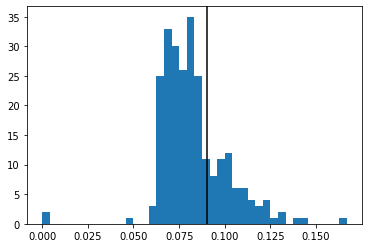

In [104]:
plt.hist(all_turn_max,bins=40);
plt.axvline(0.09,color='k')

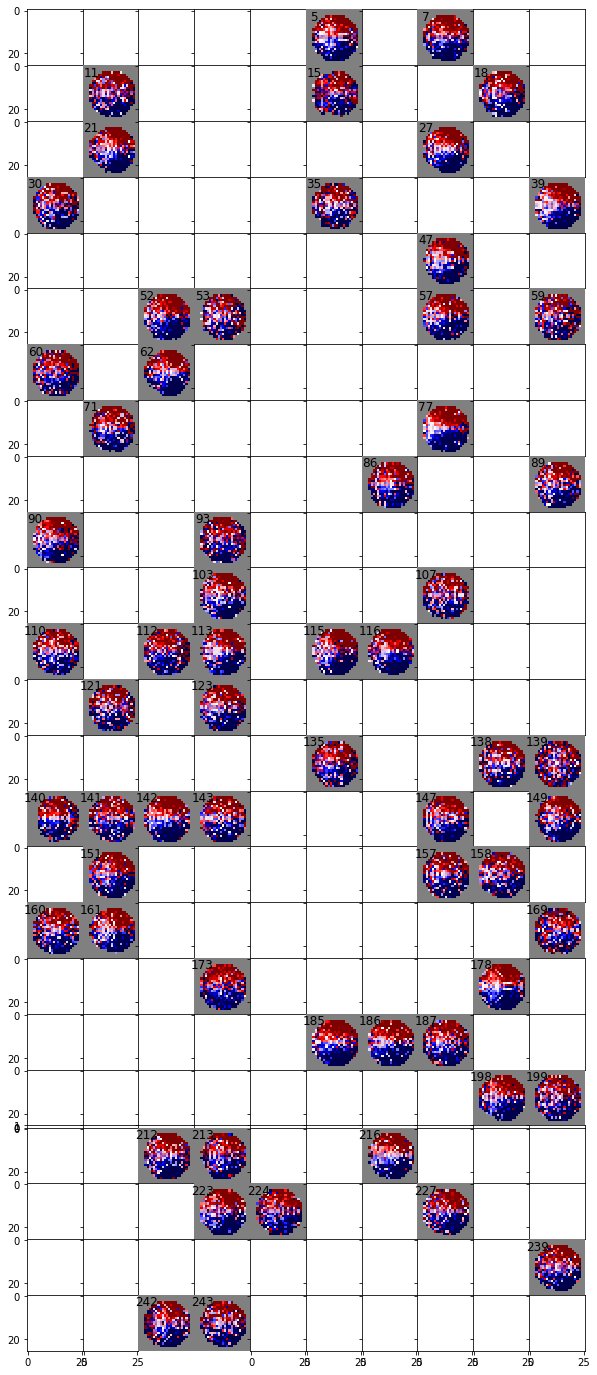

In [105]:
fig = plt.figure(figsize=(10,25))
grid = ImageGrid(fig, 111, nrows_ncols=(25, 10), axes_pad=0)

for i,ax in enumerate(grid):
    if all_turn_max[i] >.09:
        ax.imshow(all_turn_hists[i],vmin=-1,vmax=1,cmap='seismic')
        ax.set_axis_off()
        ax.set_title(i,x=.15,y=.7)
    
# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [26]:
# just inject gaussian noise into the behavior...

np.random.seed(0)
noise1 = np.random.normal(0,1,len(beh_turn))
np.random.seed(1)
noise2 = np.random.normal(0,1,len(beh_turn))

Text(0.5, 0, 'Right ROI signal')

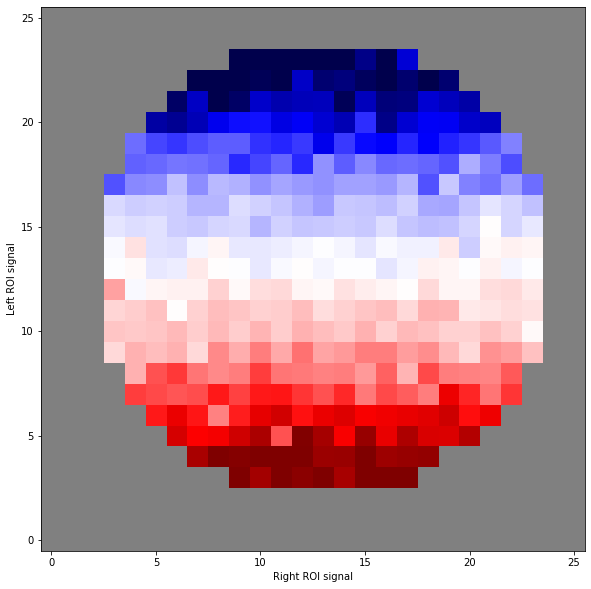

In [29]:
plt.figure(figsize=(10,10))

x_data = noise1 + np.clip(beh_turn,0,None)
y_data = noise2 - np.clip(beh_turn,None,0)

x_data = noise1 + beh_turn
y_data = noise2 - beh_turn

r = np.deg2rad(45)
rot = [[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]]
m = np.vstack((x_data,y_data)).T
out = np.matmul(m,rot)
x_data = out[:,1]; y_data = out[:,0]

behavior = beh_turn

x_data /= np.std(x_data)/0.2
y_data /= np.std(y_data)/0.2

start=-.6
stop=.6
num_bins=40
min_num_samples=10

# Define bins
bins = np.linspace(start,stop,num_bins)

# Assign neural values to bin numbers
idx_x, idx_y = np.digitize(x_data,bins), np.digitize(y_data,bins)

binned_signal_ideal = []
sample_count = []
for i in range(num_bins):
    mask_x = (idx_x == i)
    for j in range(num_bins):
        mask_y = (idx_y == j)
        mask = mask_x & mask_y

        binned_signal_ideal.append(np.mean(behavior[mask]))
        sample_count.append(np.count_nonzero(~np.isnan(behavior[mask])))

binned_signal_ideal = np.reshape(binned_signal_ideal,(num_bins, num_bins))
sample_count = np.reshape(sample_count,(num_bins, num_bins))

# Hide bins containing too few data points
binned_signal_ideal[np.where(sample_count<=min_num_samples)] = np.nan


#mask a circle
radius = 11
#binned_signal *= make_circle_aperture(num_bins,radius)
aperture = make_circle_aperture(num_bins,radius)
aperture[aperture==0]=np.nan
binned_signal_ideal*=aperture

#crop
binned_signal_ideal = binned_signal_ideal[7:-7,7:-7]

#normalize
binned_signal /= np.max(np.nan_to_num(binned_signal_ideal))

cmap = plt.cm.get_cmap("seismic")
cmap.set_bad(color='grey')
plt.imshow(binned_signal_ideal,vmin=-1,vmax=1,cmap=cmap,origin='lower')
plt.ylabel('Left ROI signal')
plt.xlabel('Right ROI signal')
#plt.plot([0,25],[0,25],color='k')
#plt.colorbar()
#plt.ylim(0,30)
#plt.xlim(0,30)
#plt.title("TURN INDEPENDENCE MODEL")
#plt.suptitle(F"Clusters {cluster_}, {cluster_+250}",y=.72)

In [30]:
binned_signal_ideal_difference = binned_signal_ideal

In [28]:
binned_signal_ideal_independence = binned_signal_ideal

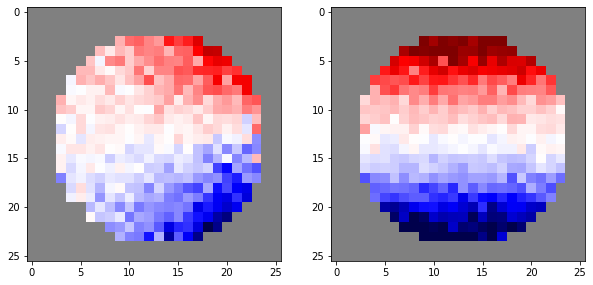

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(binned_signal_ideal_independence,cmap='seismic',vmin=-1,vmax=1)
plt.subplot(1,2,2)
plt.imshow(binned_signal_ideal_difference,cmap='seismic',vmin=-1,vmax=1)

In [37]:
from sklearn.metrics import mutual_info_score

In [139]:
corr_to_diff = []
corr_to_indep = []

for cluster in range(251):
    if all_turn_max[cluster] >.09:
        a = np.nan_to_num(all_turn_hists[cluster].flatten())
        b = np.nan_to_num(binned_signal_ideal_independence.flatten())

        r,p = scipy.stats.pearsonr(a, b)
        #r = mutual_info_score(a,b)
        corr_to_indep.append(r)

        b = np.nan_to_num(binned_signal_ideal_difference.flatten())
        #r = mutual_info_score(a,b)
        r,p = scipy.stats.pearsonr(a, b)
        corr_to_diff.append(r)
    else:
        corr_to_indep.append(0)
        corr_to_diff.append(0)

In [140]:
### optional: add a threshold for masking out near-zero corrs
diff = np.asarray(corr_to_diff)-np.asarray(corr_to_indep)
# large values (red) mean better match to DIFFERENCE style

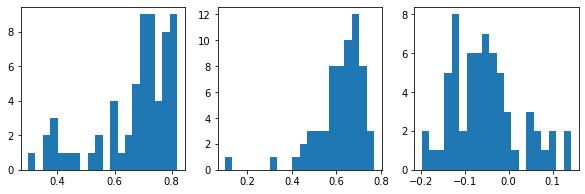

In [121]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(corr_to_indep,bins=20);
plt.subplot(1,3,2)
plt.hist(corr_to_diff,bins=20);
plt.subplot(1,3,3)
plt.hist(diff,bins=20);

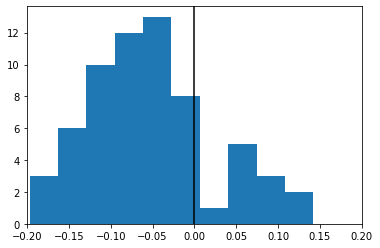

In [125]:
plt.hist(diff,bins=10);
plt.xlim(-.2,.2)
plt.axvline(0,color='k')

In [163]:
np.where(np.asarray(all_turn_max) >.09)

(array([  5,   7,  11,  15,  18,  21,  27,  30,  35,  39,  47,  52,  53,
         57,  59,  60,  62,  71,  77,  86,  89,  90,  93, 103, 107, 110,
        112, 113, 115, 116, 121, 123, 135, 138, 139, 140, 141, 142, 143,
        147, 149, 151, 157, 158, 160, 161, 169, 173, 178, 185, 186, 187,
        198, 199, 212, 213, 216, 223, 224, 227, 239, 242, 243]),)

In [147]:
np.argsort(diff)

array([139, 115, 149,  39,  62,  52, 135,  18, 158, 239, 161, 138, 198,
       178, 227, 103, 223,  86,  21, 186, 141, 151, 243,  60, 157, 187,
        89, 113,  47,  90, 169, 147, 142, 212,   5,  11, 213,  57, 216,
       123,  27,  30, 160,  15, 224, 110,   7, 199, 242, 175, 177, 174,
       172, 171, 176, 170, 179,   0, 167, 136, 137, 144, 145, 146, 148,
       150, 152, 153, 154, 155, 156, 180, 159, 162, 163, 164, 165, 166,
       168, 181, 197, 183, 220, 221, 222, 225, 226, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 240, 241, 244, 245, 246, 247,
       248, 219, 182, 218, 215, 184, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 214, 217, 134, 125, 132,  40,  41,  42,  43,  44,  45,  46,
        48,  49,  50,  51,  38,  54,  56,  58,  61,  63,  64,  65,  66,
        67,  68,  69,  70,  55,  37,  36,  34,   1,   2,   3,   4,   6,
         8,   9,  10,  12,  13,  14,  16,  17,  19,  20,  22,  2

In [150]:
diff[77]

0.040775788246541045

0.0


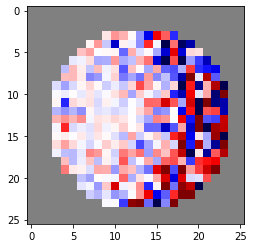

In [234]:
cluster = 124
plt.imshow(all_turn_hists[cluster],cmap='seismic',vmin=-5,vmax=5)
print(diff[cluster])

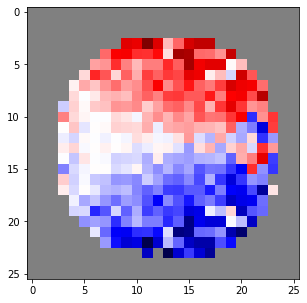

In [184]:
plt.figure(figsize=(5,5))
plt.imshow(all_turn_hists[77],cmap='seismic',vmin=-4,vmax=4)
#plt.colorbar()

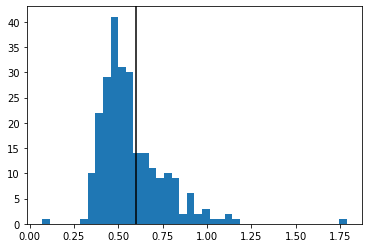

In [30]:
plt.hist(all_turn_max,bins=40);
plt.axvline(.6,color='k')

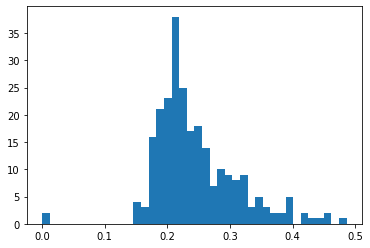

In [24]:
plt.hist(all_turn_max,bins=40);
#plt.axvline(.6,color='k')

In [96]:
diff[77]

0.040775788246541045

In [106]:
visulize_clusters = np.zeros((314, 146, 91)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(251):
    if all_turn_max[cluster]>.09:
        color = diff[cluster]
    else:
        color=0
        
    #color = diff[cluster]
    visulize_clusters[np.where(superclusters_250==cluster)] = color

In [220]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = visulize_clusters
vmax = .2#0.3
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='seismic',
                                                   diverging=True)#'hot')

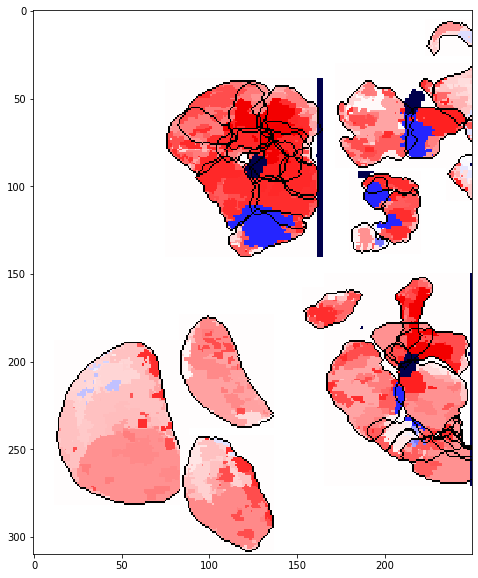

In [221]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[190:,:250])

In [42]:
atlas = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

# alternate strategy: correlation to angular velocity

In [6]:
supercluster_signals.shape, beh_turn.shape

((501, 30456), (30456,))

In [30]:
independent_corrs = []
independent_corrs1 = []
independent_corrs2 = []
diff_corrs = []
sum_corrs = []

beh_turn_left = np.clip(beh_turn,0,None)
beh_turn_right = np.clip(beh_turn,None,0)*-1

for cluster in range(250):
    a = supercluster_signals[cluster,:]
    b = supercluster_signals[cluster+250,:]
    
#     r1,p = scipy.stats.pearsonr(a, beh_turn_left)
#     r2,p = scipy.stats.pearsonr(a-b, beh_turn_left)
#     independent_corrs.append(r1)
#     diff_corrs.append(r2)
    
    
    #independent_corrs1.append(np.abs(r1))
    #independent_corrs2.append(np.abs(r2))
    #independent_corrs.append(r1)
    #independent_corrs.append((np.abs(r1)+np.abs(r2))/2)
    
    r4,p = scipy.stats.pearsonr(a+b, beh_turn)
    sum_corrs.append(r4)
    
    r3,p = scipy.stats.pearsonr(a-b, beh_turn)
    diff_corrs.append(r3)

In [29]:
sum_corrs_fwd = sum_corrs.copy()
diff_corrs_fwd = diff_corrs.copy()

In [31]:
sum_corrs_turn = sum_corrs.copy()
diff_corrs_turn = diff_corrs.copy()

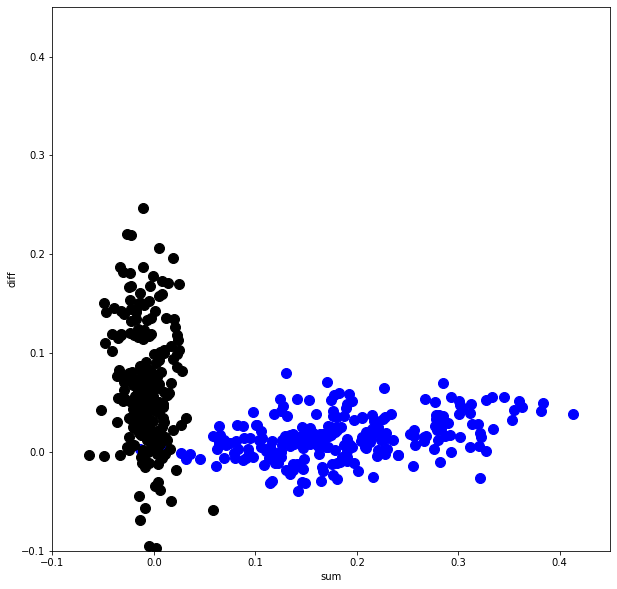

In [52]:
plt.figure(figsize=(10,10))
#plt.plot([0,1],[0,1],color='k')
plt.scatter(sum_corrs_fwd, diff_corrs_fwd,color='blue',s=100)
plt.scatter(sum_corrs_turn, diff_corrs_turn,color='k',s=100)

#plt.scatter(independent_corrs1, diff_corrs)
#plt.scatter(independent_corrs2, diff_corrs)

#plt.plot([0,1],[0,1],color='k')


plt.xlabel('sum')
plt.ylabel('diff')
plt.xlim(-.1,.45)
plt.ylim(-.1,.45)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [46]:
beh_turn_left = np.clip(beh_turn,0,None)

independent_corrs = []
independent_corrs1 = []
independent_corrs2 = []
diff_corrs = []

for cluster in range(250):
    a = supercluster_signals[cluster,:]
    b = supercluster_signals[cluster+250,:]
    
    r1,p = scipy.stats.pearsonr(a, beh_turn_left)
    r2,p = scipy.stats.pearsonr(b, beh_turn_left)
    
    independent_corrs1.append(r1)
    independent_corrs2.append(r2)
    independent_corrs.append((np.abs(r1)+np.abs(r2))/2)
    
    r3,p = scipy.stats.pearsonr(a+b, beh_turn_left)
    diff_corrs.append(r3)

In [40]:
beh_turn_right = np.clip(beh_turn,None,0)*-1

independent_corrs = []
independent_corrs1 = []
independent_corrs2 = []
diff_corrs = []

for cluster in range(250):
    a = supercluster_signals[cluster,:]
    b = supercluster_signals[cluster+250,:]
    
    r1,p = scipy.stats.pearsonr(a, beh_turn_right)
    r2,p = scipy.stats.pearsonr(b, beh_turn_right)
    
    independent_corrs1.append(r1)
    independent_corrs2.append(r2)
    independent_corrs.append((np.abs(r1)+np.abs(r2))/2)
    
    r3,p = scipy.stats.pearsonr(b-a, beh_turn_right)
    diff_corrs.append(r3)

(-0.2, 0.3)

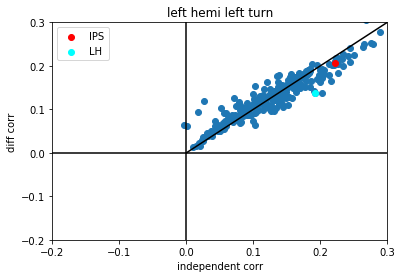

In [47]:
plt.plot([0,1],[0,1],color='k')
plt.axvline(0,color='k')
plt.axhline(0,color='k')

plt.scatter(independent_corrs1, diff_corrs)
plt.scatter(independent_corrs1[77], diff_corrs[77],color='r',label='IPS')
plt.scatter(independent_corrs1[27], diff_corrs[27],color='cyan',label='LH')
plt.legend()
plt.title('left hemi left turn')
#plt.scatter(independent_corrs1, diff_corrs)
#plt.scatter(independent_corrs2, diff_corrs)

plt.xlabel('independent corr')
plt.ylabel('diff corr')
plt.xlim(-.2,.3)
plt.ylim(-.2,.3)

In [217]:
visulize_clusters = np.zeros((314, 146, 91)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(250):
    color = diff_corrs[cluster] - independent_corrs[cluster]
    visulize_clusters[np.where(superclusters_250==cluster)] = color

In [243]:
independent_corrs[77], diff_corrs[77]

(0.12088901241170016, 0.16812472478115645)

In [244]:
temp = np.asarray(diff_corrs) - np.asarray(independent_corrs)
np.argsort(temp)

array([124, 105, 136,  36, 130,   3,  67, 167,  69,  99,  70, 214,  75,
       114, 222,  49,  29,  91, 166, 226, 170, 133,  61, 192, 244,  51,
       131, 235,  50, 234,  73, 238, 101,  48, 126, 191, 236,  83, 231,
       181, 153,  13, 209, 217,  42, 146,  23, 196, 207,  68, 210, 218,
        98, 137, 174, 241,  94,  22, 139, 108, 240, 102,  28, 119, 100,
       205,  24, 190, 117, 220,  76,  65, 193,  54,  31, 171, 202, 197,
       148,  19,  33,  55, 156, 144,  82, 127, 155,  63, 189, 176,  84,
       128, 169,  72,  32, 159,   4, 177,  56, 120, 150, 201, 164,  95,
        79, 228, 211,  58, 221,  40,  46,  66, 247,  38, 249,  97,  92,
       179,  44,  87, 168,  74,  80,  88, 183, 225, 145, 206, 180, 215,
       182,  43,  59,  37, 106, 125, 122, 107, 152, 172, 195, 141, 184,
         0,  15,  10, 111, 110,  45, 248,  20,  60,  64, 229, 188,   6,
         8,  25, 203, 132, 112,  78, 200, 204,  53, 161, 219, 237,   2,
       160, 154, 227, 243, 194,  16, 230,  93, 162, 158, 246,  3

In [245]:
temp[124]

-0.05541388396803561

In [246]:
temp[105]

-0.032889046330504004